In [95]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

model_name = "textattack/distilbert-base-uncased-SST-2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [96]:
torch.manual_seed(42)

dummy_text = ["Hello world!",
    "Testing FP32 vs BF16",
    "Model quantization",
    "The quick brown fox jumps over the lazy dog",
    "I love machine learning!",
    "Transformers are amazing for NLP tasks",
    "This is a very long sentence to test truncation and padding in tokenization",
    "Short",
    "Edge case: 1234567890",
    "Symbols !@#$%^&*()"]
inputs = tokenizer(dummy_text, padding=True, truncation=True, return_tensors="pt")
inputs = {k:v.to(device) for k,v in inputs.items()}

In [97]:
model_bf16 = AutoModelForSequenceClassification.from_pretrained(model_name, torch_dtype=torch.bfloat16).to(device)

In [98]:
fp32_mem_footprint = model.get_memory_footprint()

print("Footprint of the fp32 model in bytes: ",
      fp32_mem_footprint)
print("Footprint of the fp32 model in MBs: ", 
      fp32_mem_footprint/1e+6)

Footprint of the fp32 model in bytes:  267824136
Footprint of the fp32 model in MBs:  267.824136


In [99]:
bf16_mem_footprint = model_bf16.get_memory_footprint()

memory_relative_diff = bf16_mem_footprint / fp32_mem_footprint

print("Footprint of the bf16 model in MBs: ", 
      bf16_mem_footprint/1e+6)
print(f"Relative diff: {memory_relative_diff}")

Footprint of the bf16 model in MBs:  133.914116
Relative diff: 0.5000076468089493


- In contrast to the tiny test model earlier, DistilBERT has many layers, each layer adds up to magnify tiny numeric differences, so a logit in fp32 can be 1.2400, and the logit in bf16 can be 1.2344. This makes comparison by direct output worse for much larger models. Better ways to test model performance after dtype change is by inference/actually using it, relative difference (not memory like above, numerial rel diff), cosine similarity, prediction consistency between classes (%), etc.

In [100]:
with torch.no_grad():
    out_fp32 = model(**inputs).logits
    out_bf16 = model_bf16(**inputs).logits

In [101]:
print("FP32 output:")
print(out_fp32)
print("\nBF16 output:")
print(out_bf16)

FP32 output:
tensor([[ 1.2400, -0.8710],
        [-0.1929,  0.0829],
        [-0.0969, -0.0873],
        [ 0.2087, -0.1834],
        [ 0.7831, -0.4950],
        [ 0.0362, -0.1076],
        [ 0.3799, -0.3108],
        [-0.6513,  0.4437],
        [ 0.6156, -0.8494],
        [ 0.9300, -0.9149]], device='cuda:0')

BF16 output:
tensor([[ 1.2344, -0.8672],
        [-0.2070,  0.0957],
        [-0.1064, -0.0776],
        [ 0.2139, -0.1875],
        [ 0.7812, -0.4902],
        [ 0.0510, -0.1191],
        [ 0.3711, -0.3027],
        [-0.6523,  0.4512],
        [ 0.6016, -0.8359],
        [ 0.9297, -0.9141]], device='cuda:0', dtype=torch.bfloat16)


In [102]:
rel_diff = torch.norm(out_fp32 - out_bf16.to(torch.float32)) / torch.norm(out_fp32)
print(f"\nRelative numerical difference: {rel_diff.item():.6f}")


Relative numerical difference: 0.015128


In [103]:
pred_fp32 = out_fp32.argmax(dim=-1)
pred_bf16 = out_bf16.argmax(dim=-1)

print("FP32 predictions:", pred_fp32)
print("BF16 predictions:", pred_bf16)
print("Predictions match?", (pred_fp32 == pred_bf16).all().item())

FP32 predictions: tensor([0, 1, 1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
BF16 predictions: tensor([0, 1, 1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predictions match? True


In [104]:
cos_sim = torch.nn.functional.cosine_similarity(out_fp32.flatten(), out_bf16.flatten(), dim=0)
print(f"Cosine similarity: {cos_sim.item():.4f}")

Cosine similarity: 1.0009


In [105]:
def get_generation(model, processor, image, dtype):
  inputs = processor(image, return_tensors="pt").to(dtype)
  out = model.generate(**inputs)
  return processor.decode(out[0], skip_special_tokens=True)

In [108]:
from transformers import BlipForConditionalGeneration
from transformers import BlipProcessor

model_name_2 = "Salesforce/blip-image-captioning-base"
model = BlipForConditionalGeneration.from_pretrained(model_name_2)

processor = BlipProcessor.from_pretrained(model_name_2)

In [125]:
from IPython.display import display

img_url = 'https://wallpapers.com/images/featured/beautiful-scenery-wnxju2647uqrcccv.jpg'

In [126]:
from PIL import Image
import requests

def load_image(img_url):
    image = Image.open(requests.get(
        img_url, stream=True).raw).convert('RGB')

    return image

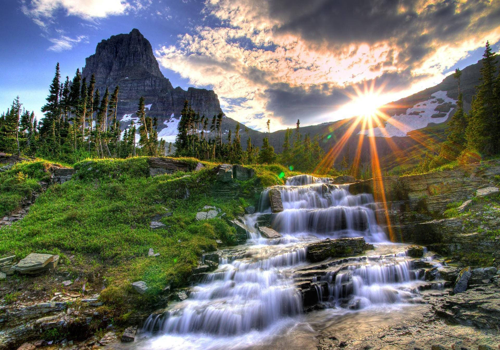

In [127]:
image = load_image(img_url)
display(image.resize((500, 350)))

In [128]:
results_fp32 = get_generation(model, 
                              processor, 
                              image, 
                              torch.float32)

print("fp32 Model Results:\n", results_fp32)

fp32 Model Results:
 a waterfall in the mountains with the sun shining over it


In [129]:
model_blip_bf16 = BlipForConditionalGeneration.from_pretrained(model_name_2, torch_dtype=torch.bfloat16)

In [130]:
results_bf16 = get_generation(model_blip_bf16, 
                              processor, 
                              image, 
                              torch.bfloat16)

print("bf16 Model Results:\n", results_bf16)

bf16 Model Results:
 a waterfall in the mountains with the sun shining over it
